In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import DatasetFolder
from PIL import Image

#Transform the Pixel Values of the Original Images to [-1,1]
tfm=transforms.Compose([transforms.Resize((64,64)),
                        transforms.ToTensor(),#[0,1]
                        transforms.Lambda(lambda t:(t*2-1))#[-1,1]
                             ])
dataset=DatasetFolder("/kaggle/input/stanford-cars-dataset/cars_train",loader=lambda x:Image.open(x),extensions='jpg',transform=tfm)

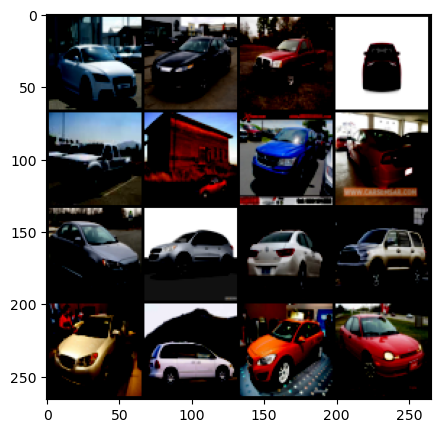

In [2]:
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset,DataLoader

images=[]
for i in range(16):
    #dataset[i]=(torch.tensor(3,64,64),0)
    a,b=dataset[i]
    images.append(a)
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(5,5))
#(64,64,3)
plt.imshow(grid_img.permute(1,2,0))
plt.show()

#Eliminate the Images Without 3 Channels
images=[]
for i in range(len(dataset)):
    a,b=dataset[i]
    if(a.shape[0]==3):
        images.append(a)


In [4]:
print(len(images))

class MyDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    def __getitem__(self,idx):
        return self.dataset[idx]
    def __len__(self):
        return len(self.dataset)

train_set=MyDataset(images)
train_loader=DataLoader(train_set,batch_size=128,shuffle=True)



8126


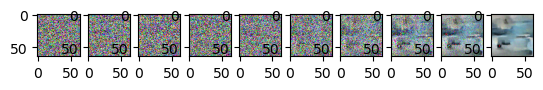

In [120]:
import torch
from torch.utils.data import DataLoader
import gc

#Pre-define the Noising Parameters   
betas=torch.linspace(0.0001,0.02,300)
#alphas=[α1，α2...α300]
alphas=1-betas
#alphas_prod=[α1,α2*α1,α3*α2*α1,...], shape[300]
alphas_prod=torch.cumprod(alphas,0)
sqrt_alphas_prod=torch.sqrt(alphas_prod)
sqrt_one_minus_alphas_prod=torch.sqrt(1-alphas_prod)

p=torch.tensor([1])
alphas_prod_prev=torch.cat([p,alphas_prod[:-1]])
phi=torch.sqrt(betas*(1-alphas_prod_prev)/(1-alphas_prod))

#forward process
#images[batch_size,3,64,64],ts[t1,t2,...t_batch_size]
#input orginal image x_0 and timestep t, output x_t and noise
def noising(images,ts):
    n=ts.shape[0]
    epsilon=torch.randn_like(images)
    images_mo=[]
    for i in range(n):
        images_mo.append((images[i]*sqrt_alphas_prod[ts[i]-1]+sqrt_one_minus_alphas_prod[ts[i]-1]*epsilon[i]).tolist())
    #epsilon [batch_size,3,64,64]
    return torch.tensor(images_mo),epsilon

recov_trans=transforms.Compose([
    transforms.Lambda(lambda t:(t+1)/2*255),
    transforms.Lambda(lambda t:t.permute(1,2,0)),
    transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
    transforms.ToPILImage()
])

#Generate New Images
def plot_new(T=300):
    im=torch.randn([1,3,64,64])
    model.eval()
    with torch.no_grad():
        for i in range(T):
            t=int(T-i)
            pred_noise=model(im.to('cuda'),torch.tensor([t]).to('cuda'))
            z=torch.randn([1,3,64,64])
            if(t!=1):
                im=1/math.sqrt(alphas[t-1])*(im-(betas[t-1])/sqrt_one_minus_alphas_prod[t-1]*pred_noise.cpu())+phi[t-1]*z
            else:
                im=1/math.sqrt(alphas[t-1])*(im-(betas[t-1])/sqrt_one_minus_alphas_prod[t-1]*pred_noise.cpu())
            if((i+1)%30==0):
                
                plt.subplot(1,10,int((i+1)/30))
                plt.imshow(recov_trans(torch.squeeze(im,dim=0).detach()))
    plt.show()


In [122]:
import torch
import torch.nn as nn
import math

#Time Embedding Block
class Sinusoidal_position_embedding(nn.Module):
    def __init__(self):
        super(Sinusoidal_position_embedding,self).__init__()
        self.dmodel=32
    def forward(self,time):
        #i:[0,0,1,1,2,2...,15,15]
        #2*i [0,0,2,2,4,4,...,30,30]
        #2i/dmodel [0,0,1/16,1/16,...,15/16,15/16]
        dmodel_half=self.dmodel/2-1 #16
        i_max=dmodel_half-1 #15
        #torch.arange(16):[0,1,...,15]
        embedding=torch.exp(-math.log(10000)*torch.arange(16).to('cuda')/dmodel_half)
        embedding=time[:,None]*embedding[None,:]
        embedding=torch.cat([embedding.sin(),embedding.cos()],dim=1)
        #embedding[[t1d1,t1d2,t1d3...]
        #          [t2d1,t2d2,t2d3...]]
        return embedding.to('cuda')

class down_block(nn.Module):
    def __init__(self,in_ch,out_ch,time_emb_dim):
        super().__init__()
        self.time_dim2out_ch=nn.Sequential(
            nn.Linear(time_emb_dim,out_ch),
            nn.ReLU()
        )
        self.conv1=nn.Conv2d(in_ch,out_ch,3,padding=1)
        self.bnorm1=nn.BatchNorm2d(out_ch)
        self.conv2=nn.Conv2d(out_ch,out_ch,3,padding=1)
        self.bnorm2=nn.BatchNorm2d(out_ch)
        self.transform=nn.Conv2d(out_ch,out_ch,4,2,1)
        self.relu=nn.ReLU()
    def forward(self,x,t):
        t=self.time_dim2out_ch(t)
        t=torch.unsqueeze(torch.unsqueeze(t,dim=2),dim=3)
        x=self.bnorm1(self.relu(self.conv1(x)))
        x=x+t
        x=self.bnorm2(self.relu(self.conv2(x)))
        x=self.transform(x)
        return x
    
class up_block(nn.Module):
    def __init__(self,in_ch,out_ch,time_emb_dim):
        super().__init__()
        self.time_dim2out_ch=nn.Sequential(
            nn.Linear(time_emb_dim,out_ch),
            nn.ReLU()
        )
        self.conv1=nn.Conv2d(in_ch*2,out_ch,3,padding=1)
        self.bnorm1=nn.BatchNorm2d(out_ch)
        self.conv2=nn.Conv2d(out_ch,out_ch,3,padding=1)
        self.bnorm2=nn.BatchNorm2d(out_ch)
        self.relu=nn.ReLU()
        self.transform=nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
    def forward(self,x,t):
        t=self.time_dim2out_ch(t)
        t=torch.unsqueeze(torch.unsqueeze(t,dim=2),dim=3)
        x=self.bnorm1(self.relu(self.conv1(x)))
        x=x+t
        x=self.bnorm2(self.relu(self.conv2(x)))
        x=self.transform(x)
        return x

#U-Net with Residual Connections and Time Embedding Block
class U_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.time_dim=32
        self.time_mlp=nn.Sequential(
                              Sinusoidal_position_embedding(),
                              #size: [batch_size,32]
                              nn.Linear(32,32),
                              nn.ReLU(),
                              )
        self.conv_0=nn.Conv2d(3,64,3,padding=1)
        
        self.down=nn.ModuleList([down_block(64,128,32),\
                                 down_block(128,256,32),\
                                 down_block(256,512,32),\
                                 down_block(512,1024,32)])
        
        
        self.up=nn.ModuleList([up_block(1024,512,32),\
                              up_block(512,256,32),\
                              up_block(256,128,32),\
                              up_block(128,64,32)])
        
        
        self.output=nn.Conv2d(64,3,1)
    def forward(self,x,t):
        t=self.time_mlp(t)
        #[bs,3,64,64]->[bs,64,64,64]
        x=self.conv_0(x)
        
        res=[]
        for i in range(len(self.down)):
            x=self.down[i](x,t)            
            res.append(x)
        for i in range(len(self.up)):
            r=res.pop()
            x=torch.cat([x,r],dim=1)
            x=self.up[i](x,t)
        x=self.output(x)
        return x

model=U_Net()
print("Num params: ", sum(p.numel() for p in model.parameters()))


Num params:  62438883


In [7]:
import torch.nn.functional as F

#Output the l1-loss between the predicted noise and the true noise 
def get_loss(images):
    global model
    t=torch.randint(1,301,(images.shape[0],)).to('cuda')
    im_m,noise=noising(images,t)
    im_m,noise=im_m.to('cuda'),noise.to('cuda')
    pred_noise=model(im_m,t).to('cuda')
    return F.l1_loss(pred_noise,noise)

'''
for i,d in enumerate(train_loader):
    if i==0:
        t=torch.randint(1,301,(d.shape[0],))
        a,b=noising(d,t)
        print(a.shape,b.shape)
'''

torch.Size([128, 3, 64, 64]) torch.Size([128, 3, 64, 64])


In [ ]:
from torch.optim import Adam

#Training Process
EPOCH=100
optimizer=Adam(model.parameters(),lr=0.0005)
model.to('cuda')

for i in range(EPOCH):
    model.train()
    for j,data in enumerate(train_loader):
        data=data.to('cuda')
        loss=get_loss(data)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('epoch:',i+1,'loss:',loss)
    plot_new()

In [125]:
torch.save(model,'diffusion.pth')